In [11]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import seaborn as sns
import scipy.stats as stats  

warnings.filterwarnings("ignore")

# 
 Importd claims_data.csv and cust_data.csv which is provided  and
combined the two datasets appropriately to create a 360-degree view of
the data. Used the same for the subsequent analysis.

In [2]:
filepath = "C:\\Users\\sudhi\\OneDrive\\Desktop\\Insurance Claims Case Study\\"
fileclaims = "claims.csv"
filecust = "cust_demographics.csv"

In [3]:
claims = pd.read_csv(filepath + fileclaims)
cust = pd.read_csv(filepath + filecust)

In [4]:
cc=pd.merge(left= claims,right= cust,left_on=claims['customer_id'],right_on=cust['CUST_ID'],how='inner')

In [5]:
cc= cc.drop('key_0',axis=1)

In [6]:
cc= cc.drop('CUST_ID',axis=1)

In [7]:
cc.head(2)

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No,Female,12-Jan-79,VT,789-916-8172,Platinum
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No,Female,13-Jan-70,ME,265-543-1264,Silver


#
 Performed a data audit for the datatypes and found  if there are any
mismatch within the current datatypes of the columns and their
business significance.

In [8]:
cc.dtypes

claim_id                 int64
customer_id              int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
dtype: object

In [9]:
cc['claim_date']=pd.to_datetime(cc['claim_date'])

In [10]:
cc['DateOfBirth'] = pd.to_datetime(cc['DateOfBirth'])

# 
Converted the column claim_amount to numeric. Used the appropriate
modules/attributes to remove the $ sign.

In [11]:
def modify(var):
        if str(var).startswith('$'):
            var = var[1:]
            return var
    

In [12]:
cc['claim_amount']=cc['claim_amount'].apply(modify)

In [13]:
cc['claim_amount'] = pd.to_numeric(cc['claim_amount'])

# 
 Of all the injury claims, some of them had gone unreported with the
police. Created an alert flag (1,0) for all such claims.

In [14]:
def alert(var):
    if var['police_report'] == 'Yes':
        return 0
    else :
        return 1

In [15]:
cc['alert'] = cc.apply(alert,axis=1)

# 
 One customer can claim for insurance more than once and in each claim,
multiple categories of claims can be involved. However, customer ID
should remain unique.
Retained the most recent observation and deleted any duplicated records in
the data based on the customer ID column.

In [16]:
cc.sort_values(by='claim_date', ascending=False, inplace=True)

In [17]:
cc.drop_duplicates(subset='customer_id', keep='first', inplace=True)

In [18]:
cc.reset_index(drop= True, inplace = True)

# 
Checking for missing values and imputed the missing values with an
appropriate value. (mean for continuous and mode for categorical)

In [19]:
cc['claim_amount'].fillna(cc['claim_amount'].mean(),inplace = True)

In [20]:
cc['claim_amount']=round(cc['claim_amount'],2)

In [21]:
cc['total_policy_claims'].fillna(cc['total_policy_claims'].mean(),inplace= True)

In [22]:
cc.isnull().sum()

claim_id               0
customer_id            0
incident_cause         0
claim_date             0
claim_area             0
police_report          0
claim_type             0
claim_amount           0
total_policy_claims    0
fraudulent             0
gender                 0
DateOfBirth            0
State                  0
Contact                0
Segment                0
alert                  0
dtype: int64

# 
 Calculated the age of customers in years. Based on the age, categorize the
customers according to the below criteria
Children < 18
Youth 18-30
Adult 30-60
Senior > 60

In [23]:
age = ((cc['claim_date'].dt.year-cc['DateOfBirth'].dt.year))

In [24]:
cc['Age']=age

In [25]:
def cat(var):
    if var < 18 :
        return "Children"
    elif (var > 18) & (var <30):
        return "Youth"
    elif (var > 30) & (var <60):
        return "Adult"
    elif (var > 60):
        return "Senior"

In [26]:
cc['Age_cat']=cc['Age'].apply(cat)

# 
the average amount claimed by the customers from various
segments

In [27]:
cc.groupby(by=['Segment']).agg(Avg_Amount=('claim_amount',np.mean))

,Avg_Amount
Segment,
Gold,12846.400431
Platinum,12371.654986
Silver,12267.859653


# 
 the total claim amount based on incident cause for all the claims
that have been done at least 20 days prior to 1st of October, 2018.(Selected this date randomly)

In [28]:
date = "2018-10-1"

In [29]:
date=dt.strptime(date, '%Y-%m-%d')

In [30]:
sort_date=date - pd.Timedelta(days=20)

In [31]:
q9=cc.loc[(cc['claim_date']<sort_date)]

In [32]:
q9.groupby(by=['incident_cause']).agg(Total_claim_amount=('claim_amount',sum)).reset_index()

,incident_cause,Total_claim_amount
0,Crime,721938.65
1,Driver error,3315850.76
2,Natural causes,1312987.07
3,Other causes,3723151.87
4,Other driver error,3277536.49


#
 number of adults from TX, DE and AK claimed insurance for driver
related issues and causes?

In [33]:
q10=cc.loc[(cc['State'].isin(['TX','DE','AK']))]

In [34]:
q10=q10.loc[(q10['incident_cause']=='Driver error')]

In [35]:
print(len(q10),"adults from TX, DE and AK claimed insurance for driver related issues and causes")

22 adults from TX, DE and AK claimed insurance for driver related issues and causes


# 
 pie chart between the aggregated value of claim amount based
on gender and segment.

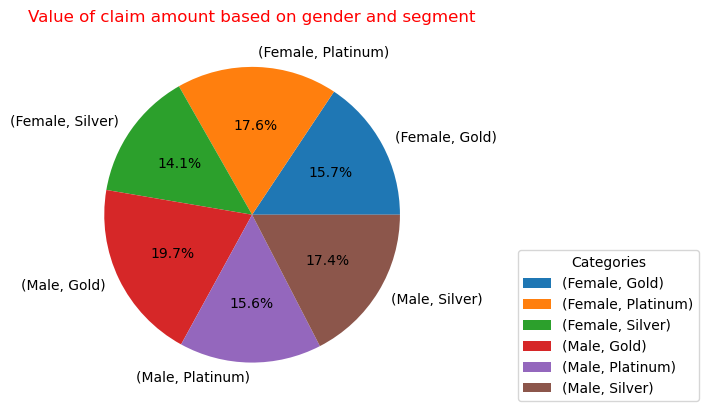

In [36]:
cc.groupby(by=['gender','Segment']).agg(Claim_Amount=('claim_amount',sum)).plot(kind='pie',subplots=True,autopct='%1.1f%%')
plt.figsize=((20,40))
plt.legend( title="Categories", loc="center left", bbox_to_anchor=(1.2,0.2))
plt.ylabel("")
plt.title("Value of claim amount based on gender and segment",c='r')
plt.show()


#
 Among males and females, found which gender had claimed the most for any
type of driver related issues? 

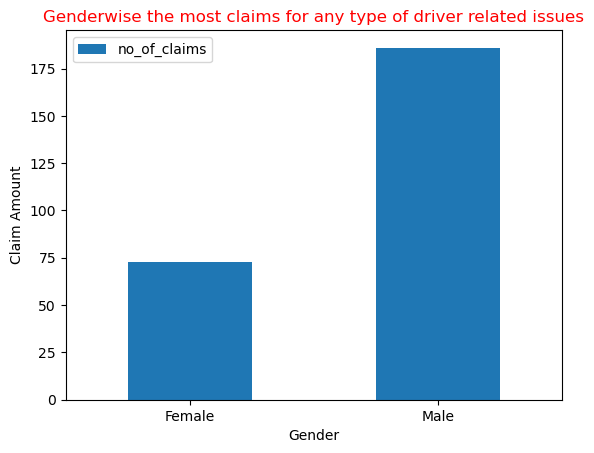

In [37]:
cc.loc[cc['incident_cause']=='Driver error'].groupby(by=['gender']).agg(no_of_claims=('gender',len)).plot(kind='bar')
plt.title("Genderwise the most claims for any type of driver related issues",c='r')
plt.xticks(rotation=0)
plt.xlabel("Gender")
plt.ylabel("Claim Amount")
plt.show()


#
 age group that had the maximum fraudulent policy claims

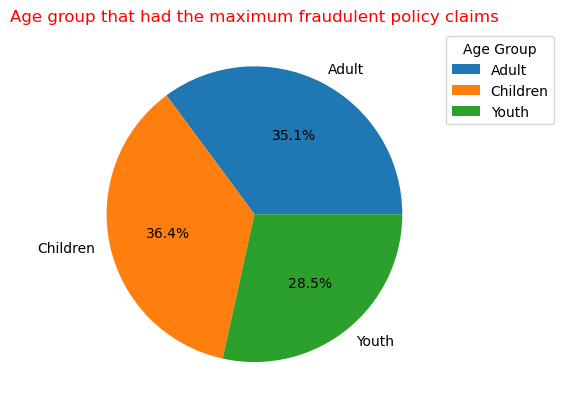

In [38]:
cc.loc[(cc['fraudulent']=='Yes')].groupby(by=['Age_cat']).agg(no_of_claims=('gender',len)).plot(kind='pie',subplots=True,autopct='%1.1f%%')
plt.ylabel("")
plt.title("Age group that had the maximum fraudulent policy claims",c='r')
plt.legend(title='Age Group',bbox_to_anchor=(1,1))
plt.show()

# 
 Visualized the monthly trend of the total amount that has been claimed
by the customers.

In [39]:
month_name=cc['claim_date'].dt.strftime('%B')

In [40]:
cc['Month']=month_name

In [41]:
q14=cc.groupby(by=['Month']).agg(Total_Amount=('claim_amount',sum))

In [42]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [43]:
q14=q14.loc[month_order]

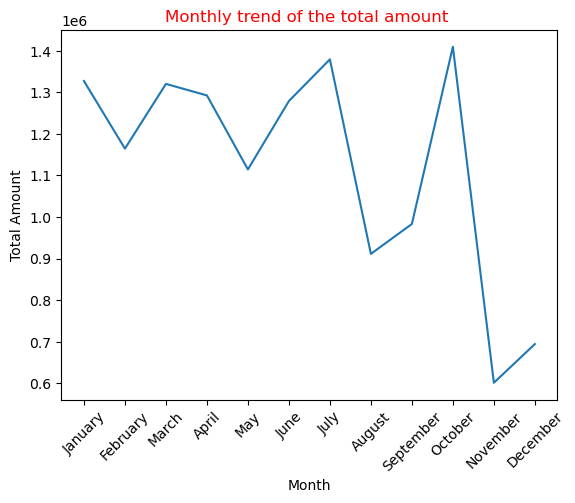

In [44]:
fig, ax = plt.subplots()
ax.plot(q14.index,q14.Total_Amount, label='Line Chart')
plt.title("Monthly trend of the total amount ",c='r')
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.xticks(rotation=45)
plt.show()

#
the average claim amount for gender and age categories and
suitably represented the above using a facetted bar chart, one facet that
represented fraudulent claims and the other for non-fraudulent claims.

In [45]:
q15=cc.groupby(by=['gender','Age_cat','fraudulent']).agg(Claim_amount=('claim_amount',sum)).reset_index()

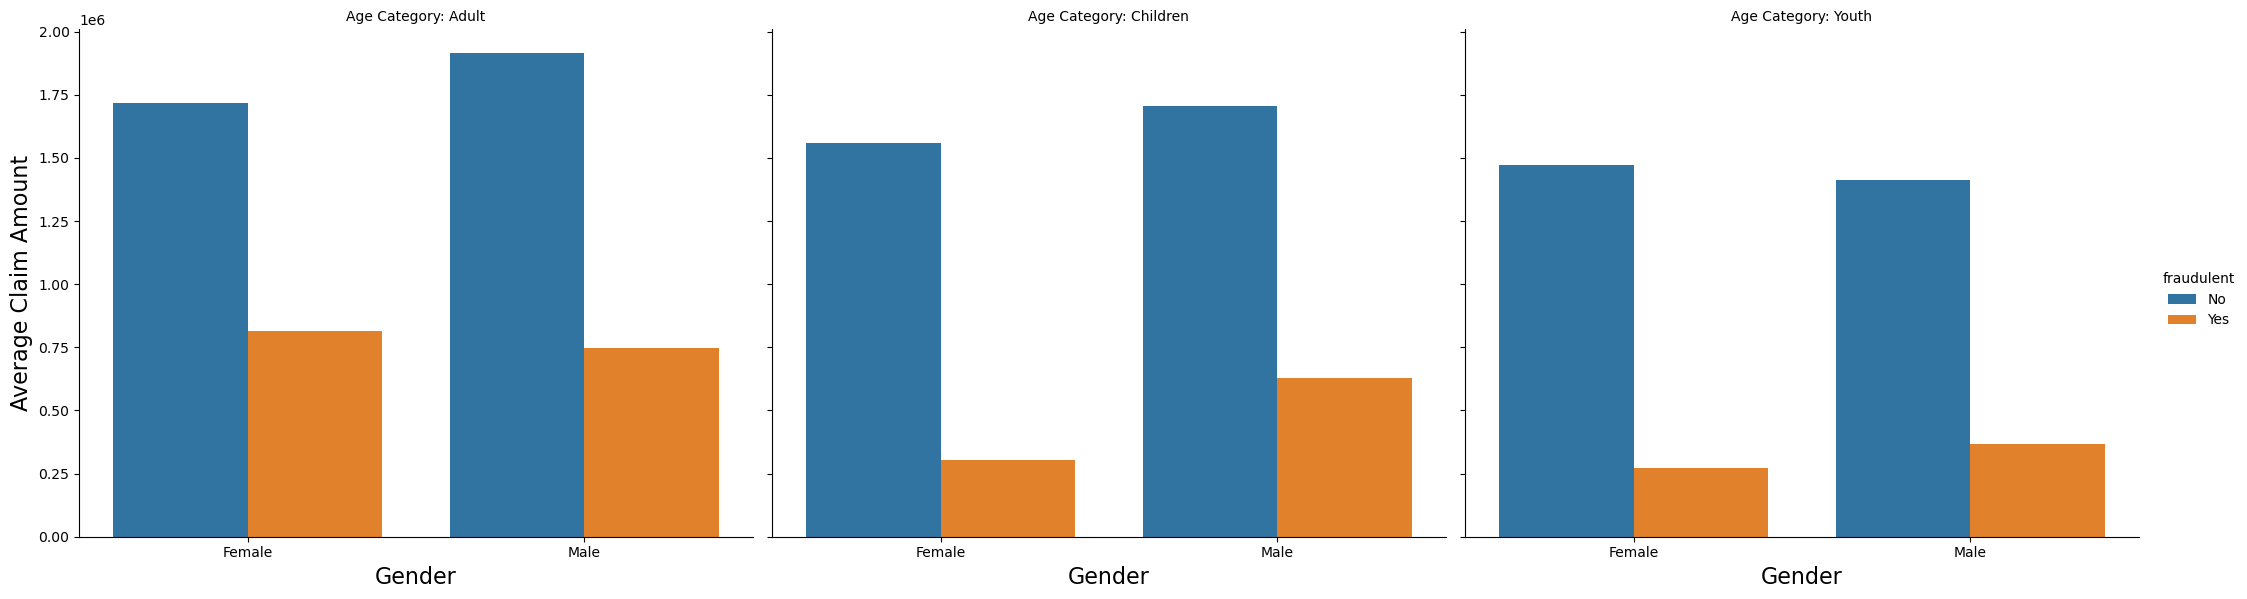

<Figure size 2000x1600 with 0 Axes>

In [46]:
plt.figsize=((10,10))
g = sns.catplot(
    x='gender',
    y='Claim_amount',
    hue='fraudulent',
    col='Age_cat',
    data=q15,
    kind='bar',
    height=6,
    aspect=1.2)
g.set_axis_labels("Gender", "Average Claim Amount",fontsize= 16)
g.set_titles("Age Category: {col_name}",fontsize=18)
g.set_xticklabels(fontsize= 10)
plt.figure(figsize=(20, 16)) 
plt.show()

# 
Found if there any similarity in the amount claimed by males and females?

In [47]:
q16=cc.groupby(by=['gender']).agg(Amount=('claim_amount',sum)).reset_index()

In [48]:
var = "claim_amount"
male = cc.loc[cc.gender=="Male",var]
female = cc.loc[cc.gender == "Female",var]

In [49]:
print('Claim amount mean for male:', male.mean())
print('Claim amount mean for female:',female.mean() )

Claim amount mean for male: 12884.845335753174
Claim amount mean for female: 12101.160664136622


In [50]:
# Defining the hypothesis
# H0 : male and female amount claims are similar
# Ha: male and female claims are not similar
# CI: 99%, p/alpha: 0.01

In [51]:
# SInce these are independent numerical columns and std deviation is not provided, we will perform independent t test

In [52]:
stats.ttest_ind( male, female )

Ttest_indResult(statistic=0.962509388314579, pvalue=0.3360100394474975)

In [53]:
#Conclusion: Since p value is more for H0 becomeing true is more Therefore
# We fail to reject null hypothesis and claim that male and female claims are similar

#
Found if there any relationship between age category and segment?

In [54]:
#Since gender and segment both are categorical columns we shall perform a chisquare hypothesis test.

In [55]:
obs_freq = pd.crosstab( cc.gender, cc.Segment )
obs_freq

Segment,Gold,Platinum,Silver
gender,,,
Female,171,193,163
Male,200,168,183


In [56]:
# Defining the Hypothesis
# Ho: No relationship b/w gender and segment
# Ha: Association b/w region and segment
# CI: 99%, p: 0.01


In [57]:
stats.chi2_contingency( obs_freq )

Chi2ContingencyResult(statistic=4.622185882769289, pvalue=0.09915282409315045, dof=2, expected_freq=array([[181.37012987, 176.48144712, 169.14842301],
       [189.62987013, 184.51855288, 176.85157699]]))

In [58]:
# Conclusion: Since p value for H0 becoming true is more Therefore
# we fail to reject null hypothesis and claims no relationship b/w gender and segment


# 
The current year has shown a significant rise in claim amounts as
compared to 2016-17 fiscal average which was $10,000.

In [59]:
mean_sample=cc['claim_amount'].mean()
pop_mean = 10000
sample = cc['claim_amount']

In [60]:
print("Mean of last year claim amount:",pop_mean)
print("Mena of this year claim amount:",mean_sample)

Mean of last year claim amount: 10000
Mena of this year claim amount: 12501.72676252319


In [61]:
# Defining the hypothesis
# H0 : No Significant rise in mean of claim amount
# Ha: Significant rise in mean of claims amount
# CI: 99%, p: 0.01

In [62]:
stats.ttest_1samp(a = sample, popmean = pop_mean)

TtestResult(statistic=6.146897698482048, pvalue=1.1110844570623794e-09, df=1077)

In [63]:
#Conclusion: Since p value for H0 beacoming true is more Therefore 
# we fail to reject H0 and claim that there is no significant rise in claim amount

# 
found if there any difference between age groups and insurance claims?

In [64]:
var = 'claim_amount'
s1 = cc.loc[ cc.Age_cat == "Children",var]
s2 = cc.loc[ cc.Age_cat == "Adult",var]
s3 = cc.loc[ cc.Age_cat == "Senior",var]

In [65]:
print( 'mean of s1: ', s1.mean(), '| mean of s2: ', s2.mean(), '| mean of s3: ', s3.mean() )

mean of s1:  11929.405227272726 | mean of s2:  13782.045145888593 | mean of s3:  nan


In [66]:
# H0: There is no significant difference in insurance claims among different age groups
# Ha: There is significant difference in insurance claims among different age groups
# CI: 99%, p: 0.01

# perform the test
stats.f_oneway( s1, s2)


F_onewayResult(statistic=3.410935858919763, pvalue=0.06517190288708086)

In [67]:
#Conclusion: Since the p value for H0 becoimg true is more Therefore
# we fail to reject H0 and claims that there is no significant difference in insurance claims among different age groups

#
found if there any relationship between total number of policy claims and the
claimed amount?

In [68]:
x=cc['total_policy_claims']

In [69]:
y= cc['claim_amount']

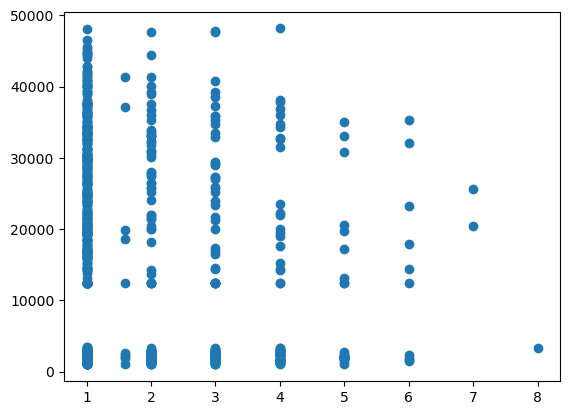

In [70]:
plt.scatter(x,y)
plt.show()

In [71]:
print(" There is NO any relationship between total number of policy claims and the claimed amount")

 There is NO any relationship between total number of policy claims and the claimed amount
